# Exploratory Data Analysis (EDA)

Analyze the German Credit dataset to understand patterns and inform feature engineering.

## 1. Setup

In [12]:
# Core data science libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2_contingency
from typing import Optional, List, Union, Tuple

# Project utilities
from test_case_fairmoney.utils.constants import PATH_DATA_RAW, PATH_DATA_COMPRESSED
from test_case_fairmoney.utils.eda import (
    plot_boolean_conversion_rate,
    plot_all_categorical_features,
    cramers_v_matrix_fast,
    plot_feature_analysis,
    plot_correlation_matrix,
    get_high_correlations,
    plot_feature_distributions,
)
from test_case_fairmoney.utils.cramers_v1 import cramers_v1

# Configuration
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 800)
warnings.filterwarnings("ignore")

# Plotting style
plt.style.use("default")
sns.set_palette("husl")
pd.set_option("display.float_format", "{:.0f}".format)  # No decimal places

## 2. Load Data

In [13]:
df = pd.read_parquet(PATH_DATA_COMPRESSED / "credit_processed.parquet")

In [14]:
# Load the optimized German Credit dataset
print("Loading German Credit Dataset...")
# Quick overview
print(f"\nDataset Overview:")
print(f"Records: {len(df):,}")
print(f"Features: {len(df.columns)}")
print(f"Default Rate: {df['default'].mean():.4f} ({df['default'].mean()*100:.2f}%)")

# Class distribution
default_dist = df["default"].value_counts()
imbalance_ratio = default_dist[0] / default_dist[1] if len(default_dist) > 1 else 0
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")
if imbalance_ratio > 10:
    print("⚠️ Significant class imbalance detected")

Loading German Credit Dataset...

Dataset Overview:
Records: 1,000
Features: 24
Default Rate: 0.3000 (30.00%)
Class imbalance ratio: 2.3:1


In [15]:
print("Data types:", df.dtypes.value_counts())

Data types: object     12
int64       8
float64     4
Name: count, dtype: int64


## 3. Define Features

In [16]:
target = ["default"]
feat_cat = [
    "credit_history",
    "purpose",
    "personal_status",
    "other_debtors",
    "is_phone_nigeria",
    "property",
    "installment_plan",
    "housing",
    "foreign_worker",
    "job",
    "gender",
    "telephone_country_code",
    "telephone_mobile_network",
]
feat_num = [
    "checking_balance",
    "months_loan_duration",
    "amount",
    "savings_balance",
    "installment_rate",
    "existing_credits",
    "dependents",
    "residence_months",
    "employment_months",
    "is_checking_negative",
]

## 4. Missing Data Analysis

Columns with missing data:
                          Missing_Count  Missing_Percentage
telephone_country_code              596                  60
telephone_mobile_network            596                  60
checking_balance                    394                  39
personal_status                     310                  31
savings_balance                     183                  18
residence_months                    130                  13
employment_months                    62                   6


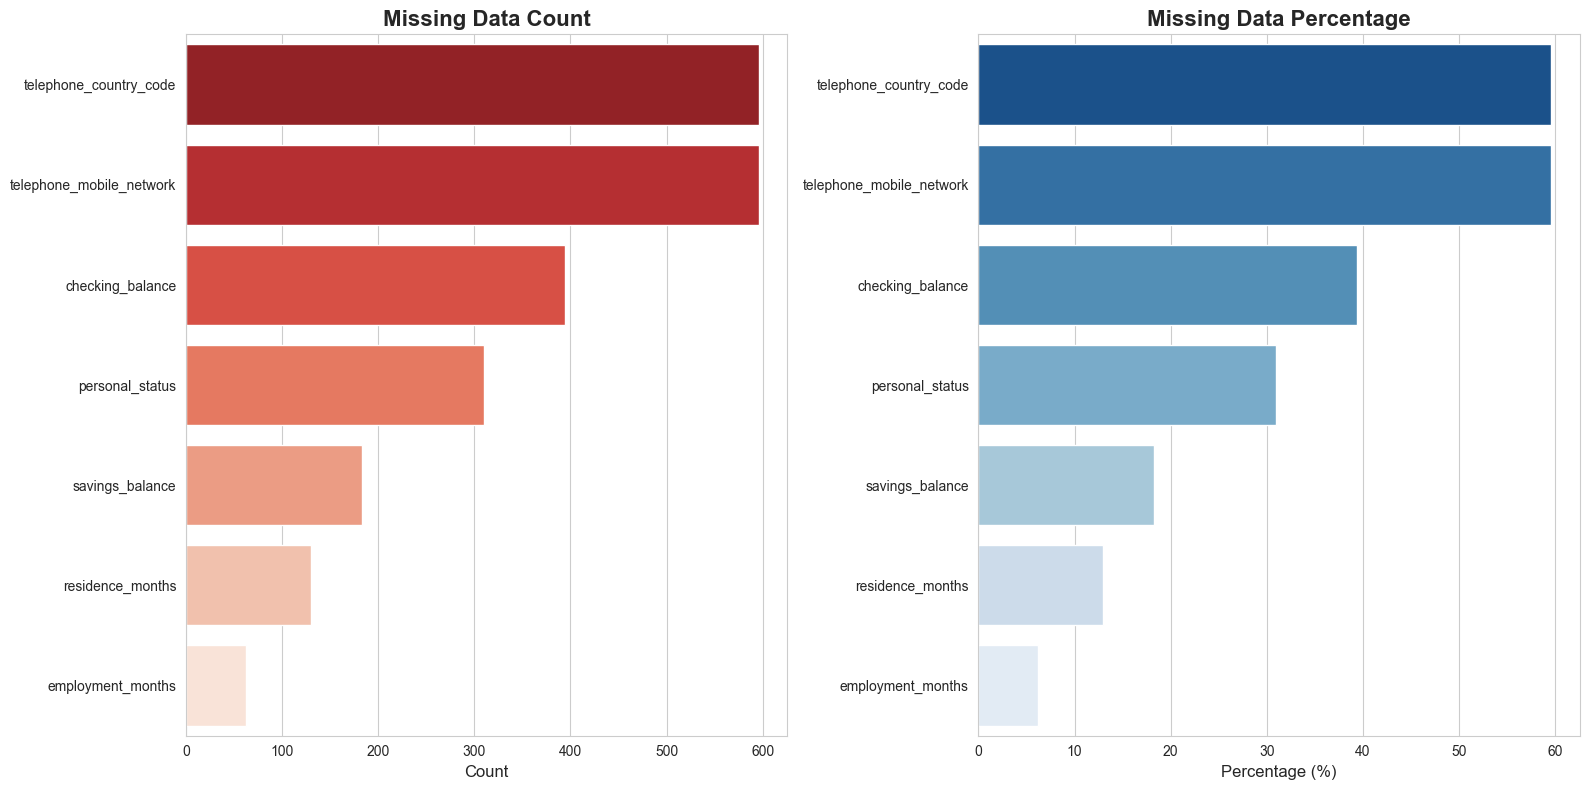

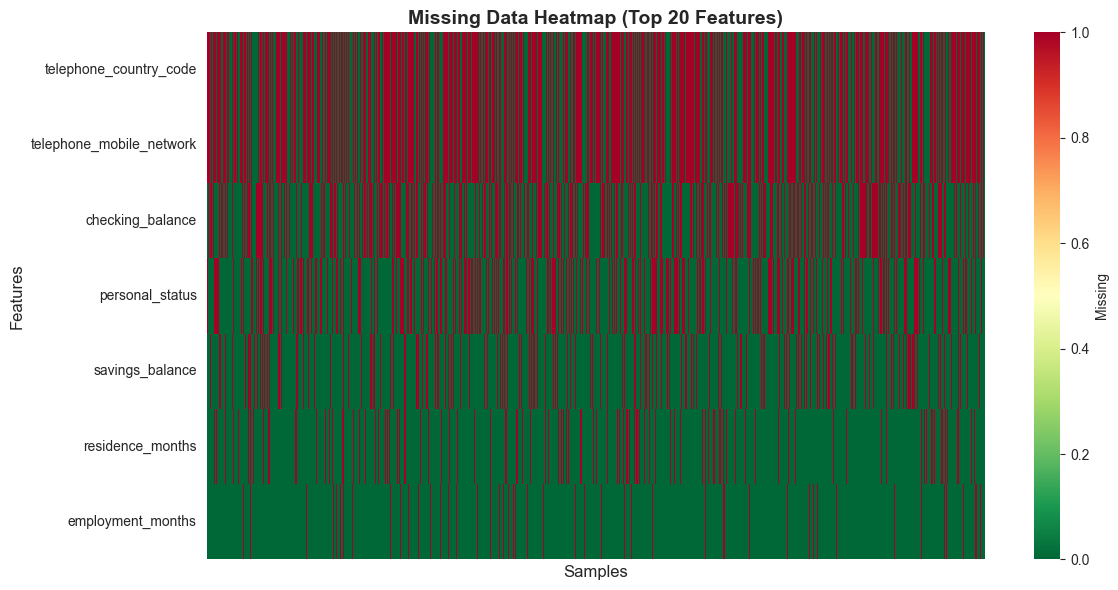

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

# Analyze missing data
missing_data = df.isna().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(df) * 100).round(2)

missing_summary = pd.DataFrame(
    {"Missing_Count": missing_data, "Missing_Percentage": missing_percentage}
)
# Filter to show only columns with missing data
missing_summary_filtered = missing_summary[missing_summary["Missing_Count"] > 0]

if len(missing_summary_filtered) > 0:
    print("Columns with missing data:")
    print(missing_summary_filtered)

if len(missing_summary_filtered) > 0:
    # Get top 20
    top_20 = missing_summary_filtered.head(20)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Count
    sns.barplot(x=top_20["Missing_Count"], y=top_20.index, palette="Reds_r", ax=axes[0])
    axes[0].set_title("Missing Data Count", fontsize=16, fontweight="bold")
    axes[0].set_xlabel("Count", fontsize=12)
    axes[0].set_ylabel("")

    # Plot 2: Percentage
    sns.barplot(
        x=top_20["Missing_Percentage"], y=top_20.index, palette="Blues_r", ax=axes[1]
    )
    axes[1].set_title("Missing Data Percentage", fontsize=16, fontweight="bold")
    axes[1].set_xlabel("Percentage (%)", fontsize=12)
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

    # Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        df[top_20.index].isna().T,
        cmap="RdYlGn_r",
        cbar_kws={"label": "Missing"},
        yticklabels=True,
        xticklabels=False,
    )
    plt.title("Missing Data Heatmap (Top 20 Features)", fontsize=14, fontweight="bold")
    plt.ylabel("Features", fontsize=12)
    plt.xlabel("Samples", fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("✓ No missing data to visualize!")

#### Comments:

There are 7 features with missing values. For simplicity, missing value imputation will not be performed in this analysis for the following reasons:

- **For Logistic Regression**: We will use Weight of Evidence (WOE) encoding, which naturally handles missing values
- **For Tree-Based Models**: These algorithms can handle missing values natively

**Action Required**: For categorical features only, convert NaN values to the explicit category 'Missing'

## 5. Categorical Features Analysis

In [18]:
all_stats = plot_all_categorical_features(df, feat_cat, target_col=target)


PLOTTING: credit_history



Completed credit_history

PLOTTING: purpose



Completed purpose

PLOTTING: personal_status



Completed personal_status

PLOTTING: other_debtors



Completed other_debtors

PLOTTING: is_phone_nigeria



Completed is_phone_nigeria

PLOTTING: property



Completed property

PLOTTING: installment_plan



Completed installment_plan

PLOTTING: housing



Completed housing

PLOTTING: foreign_worker



Completed foreign_worker

PLOTTING: job



Completed job

PLOTTING: gender



Completed gender

PLOTTING: telephone_country_code



Completed telephone_country_code

PLOTTING: telephone_mobile_network



Completed telephone_mobile_network


#### Comments:

**credit_history**: 
- ⚠️ **Data Quality Concern**: The default rates for 'fully repaid this bank' and 'fully repaid' are the highest, significantly exceeding 'critical delay'. This is counterintuitive and suggests a potential data quality issue that requires investigation.

**purpose**: 
- Loans for 'education' show the highest default rate
- 'Retraining' loans have the lowest default rate

**personal_status**: 
- Single borrowers have lower default rates compared to married and divorced individuals

**other_debtors**: 
- Loans with a 'guarantor' demonstrate the lowest default risk

**is_phone_nigeria**: 
- Loans with Nigerian phone registrations show lower default rates compared to international phone numbers

**property**: 
- Real property ownership correlates with the lowest default risk
- 'Unknown' property status shows the highest risk

**installment_plan**: 
- Borrowers with existing loans at other banks show significantly higher risk

**housing**: 
- Homeowners demonstrate much lower default rates than renters

**foreign_worker**: 
- Foreign workers show substantially higher default rates

**job**: 
- ⚠️ **Unexpected Pattern**: Management and self-employed individuals show the highest risk, while unskilled residents show lower risk. This counterintuitive finding warrants further investigation.

**gender**: 
- Male borrowers show lower default rates than female borrowers

**telephone_country_code**: 
- No insights

## Feature-Level Risk Patterns:

| Feature | Key Observations | Notes |
|---------|-----------------|-------|
| **credit_history** | 'Fully repaid' categories show highest default rates | ⚠️ Counterintuitive - possible data quality issue |
| **purpose** | Education (highest risk), Retraining (lowest risk) | - |
| **personal_status** | Single < Married/Divorced | - |
| **other_debtors** | Guarantor presence = lowest risk | - |
| **is_phone_nigeria** | Nigerian phone = lower risk | - |
| **property** | Real property (safest), Unknown (riskiest) | - |
| **installment_plan** | Other bank loans = very high risk | - |
| **housing** | Homeowners << Renters | - |
| **foreign_worker** | Foreign workers = much higher risk | - |
| **job** | Management/Self-employed (highest risk), Unskilled (lower risk) | ⚠️ Counterintuitive pattern |
| **gender** | Male < Female | - |
| **telephone_country_code** |No insights | - |

**Data Quality Concerns**: Two features show unexpected patterns that require validation before modeling.

### Correlation Analysis (Cramér's V) for categorical features

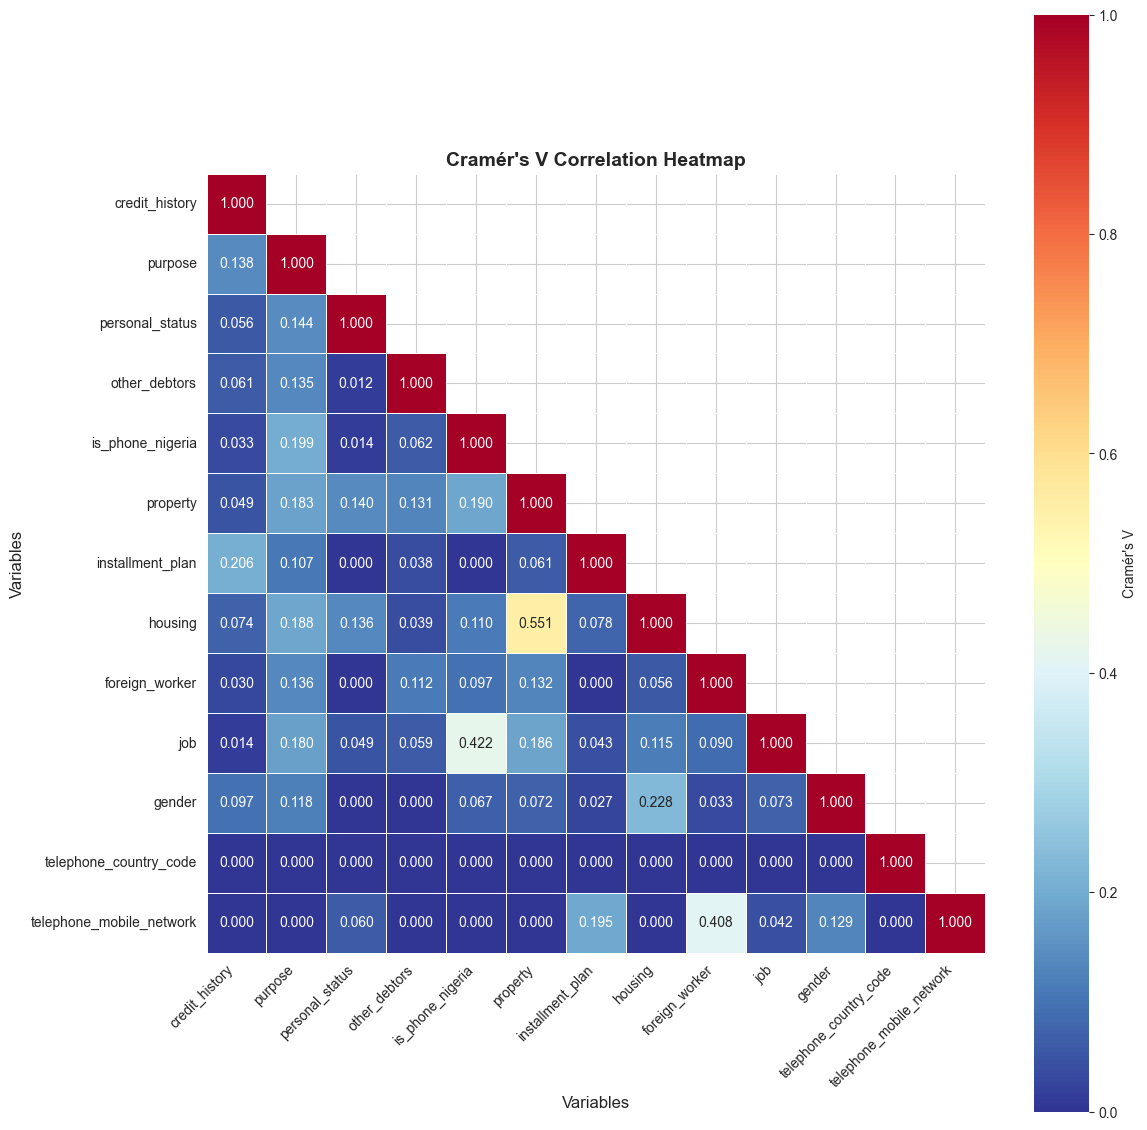

In [19]:
# Fast and optimized call
result = cramers_v_matrix_fast(
    df[feat_cat],
    feat_cat,
    max_categories=50,  # Lower for speed!
    plot=True,  # Or False to just get the matrix
    verbose=False,  # Turn on if you want progress printouts
    figsize=(12, 12),
)

#### Comments:

* No pair with high correlation

## 6. Numerical Features Analysis

### Distributions

In [20]:
# Example usage:
fig = plot_feature_distributions(df, feat_num)
fig.show()

### Feature Analysis by Target

In [21]:
fig = plot_feature_analysis(
    df=df,
    feat_num=feat_num,
    target_col="default",
    target_values=(0, 1),
    target_labels=("No Default", "Default"),
    colors=("steelblue", "coral"),
)
fig.show()

#### Comments:

=> No outliers


**checking_balance:**
- Non-defaulters generally maintain higher checking account balances

**months_loan_duration:**
- Non-defaulters tend to have shorter loan durations

**amount:**
- Non-defaulters typically borrow lower amounts

**saving_balance:**
- Non-defaulters generally maintain higher savings balances

**installment_rate:**
- Non-defaulters have lower installment rates

**existing_credits:**
- Non-defaulters have slightly more existing credits

**depends:**
- No significant difference observed between defaulters and non-defaulters

**residence_months:**
- Non-defaulters generally have longer residence durations

**employment_months:**
- Non-defaulters generally have longer employment durations

**is_checking_negative:**
- Non-defaulters tend not to have negative checking balances


## Numerical Features: Default vs Non-Default Patterns

| Feature | Non-Default Pattern | Relationship to Default |
|---------|-------------------|------------------------|
| **checking_balance** | Higher balances | Inverse relationship |
| **months_loan_duration** | Shorter durations | Inverse relationship |
| **amount** | Lower loan amounts | Inverse relationship |
| **saving_balance** | Higher savings | Inverse relationship |
| **installment_rate** | Lower rates | Inverse relationship |
| **existing_credits** | Slightly higher | Positive relationship |
| **residence_months** | Longer residence | Inverse relationship |
| **employment_months** | Longer employment | Inverse relationship |
| **is_checking_negative** | Less likely negative | Inverse relationship |
| **depends** | No difference | No relationship |

**Summary**: Most numerical features show clear separation between default and non-default groups, with non-defaulters demonstrating stronger financial stability (higher balances, longer employment/residence, no negative checking) and more conservative borrowing behavior (lower amounts, shorter durations).


### Correlation Matrix

In [39]:
fig, corr_matrix = plot_correlation_matrix(df, feat_num)
fig.show()

In [40]:
# Check high correlations
fig, corr_matrix = plot_correlation_matrix(df, feat_num)
high_corr = get_high_correlations(corr_matrix, threshold=0.7)
print("High correlations:", high_corr)

High correlations: Empty DataFrame
Columns: []
Index: []


## 7. Save Processed Data

In [ ]:
# Drop redundant features
feat_drop = ["is_phone_nigeria"]
df.drop(columns=feat_drop).to_parquet(
    PATH_DATA_COMPRESSED / "credit_processed.parquet", index=False
)
print(f"✅ Saved processed data (dropped: {feat_drop})")

## Summary

✅ **EDA Complete**: Analyzed categorical and numerical features  
✅ **Data Quality**: No major issues detected  
✅ **Correlations**: Identified and removed redundant features  
⏭️ **Next**: Train/test split